In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,macd_diff_12_26_9,ret,eng_macd,macd_line_12_26_9,obv_diff_14,eng_atr_div,eng_adx,hour,adx_14,close_raw,signal
2004-01-02 09:33:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.301415e-09
2004-01-02 09:34:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.405474e-09
2004-01-02 09:35:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.517855e-09
2004-01-02 09:36:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.639221e-09
2004-01-02 09:37:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.770291e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.888941,0.642346,0.634772,0.971125,1.000000,0.664288,0.537709,-0.975989,0.301944,196.815000,6.849078e-01
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.840741,0.340442,0.633511,0.981544,0.000000,0.676887,0.541855,-0.975989,0.328685,196.675000,6.122057e-01
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.777896,0.494192,0.631866,0.983006,0.000000,0.584662,0.545337,-0.975989,0.353515,196.670000,6.104678e-01
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.456523,0.009795,0.623450,0.884486,0.000000,0.645760,0.531521,-0.975989,0.348960,196.240000,4.770902e-01


In [4]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df             = df_feat_sel,
    look_back      = params.look_back_tick,
    sess_start     = params.sess_start_pred_tick,
    train_prop     = params.train_prop,
    val_prop       = params.val_prop,
    train_batch    = params.hparams["TRAIN_BATCH"],
    num_workers    = params.hparams["NUM_WORKERS"],
    prefetch_factor= params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh  = params.best_optuna_params["buy_threshold"],
    return_thresh  = 0.01  # flat‐zone threshold for returns
)

for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)


Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

--- TRAIN ---
 calendar days : 3840  (2004-01-02 → 2019-04-04)
 windows       : 1731840  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches= 60, batch_size=64, workers=12, pin_memory=True

--- VAL ---
 calendar days : 751  (2019-04-05 → 2022-03-28)
 windows       : 338701  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches=751, batch_size=1, workers=0, pin_memory=True

--- TEST ---
 calendar days : 809  (2022-03-29 → 2025-06-18)
 windows       : 364859  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches=809, batch_size=1, workers=0, pin_memory=True



In [5]:
# -----------------------------------------------------------------------------
# Instantiate the ModelClass & move to device
# -----------------------------------------------------------------------------

model = params.model_selected.ModelClass(
    n_feats        = len(params.features_cols_tick),                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT'],
    conv_k         = params.hparams['CONV_K'],
    conv_dilation  = params.hparams['CONV_DILATION'],
    smooth_k         = params.hparams['SMOOTH_K'],
    smooth_dilation  = params.hparams['SMOOTH_DILATION']
)
model.to(params.device)  

model

ModelClass(
  (conv): Conv1d(17, 17, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (short_lstm): LSTM(17, 64, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (ln_short): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (do_short): Dropout(p=0.25, inplace=False)
  (long_lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (short2long): Linear(in_features=128, out_features=128, bias=True)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (do_long): Dropout(p=0.3, inplace=False)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
  (cls_ter): Linear(in_features=128, out_features=3, bias=True)
  (smoother): Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)
)

In [6]:
# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models_core.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0002
    lr: 0.0002
    maximize: False
    weight_decay: 0.003
)

In [7]:
# -----------------------------------------------------------------------------
# Helper: extract the true “signal” values from any loader into a flat array
# -----------------------------------------------------------------------------
def extract_y(loader):
    return np.concatenate([batch[1].cpu().numpy().ravel() for batch in loader])

# Pull out train & validation targets
y_train = extract_y(train_loader)
y_val   = extract_y(val_loader)

# -----------------------------------------------------------------------------
# 1) Zero‐forecast baseline RMSE (predict 0 always)
#    RMSE_zero = √(mean(y²))
# -----------------------------------------------------------------------------
rmse_zero_train = np.sqrt(np.mean(y_train**2))
rmse_zero_val   = np.sqrt(np.mean(y_val**2))
print(f"Zero‐forecast RMSE (predict 0): train = {rmse_zero_train:.6f},  val = {rmse_zero_val:.6f}\n")

# -----------------------------------------------------------------------------
# 2) Compute mean, variance & std for train/validation targets
#    and derive the mean‐predictor baseline (R² = 0)
# -----------------------------------------------------------------------------
for split, y in [("Train", y_train), ("Validation", y_val)]:
    mean_y    = y.mean()
    std_y     = y.std(ddof=0)     # population std = √variance
    var_y     = std_y**2
    rmse_mean = std_y            # RMSE_baseline = std(target)

    print(f"{split} target stats:")
    print(f"  mean = {mean_y:.4f},  var = {var_y:.4f},  std = {std_y:.4f}")
    print(f"{split} mean‐predictor baseline:")
    print(f"  RMSE_baseline = {rmse_mean:.6f}")
    print("  R²_baseline   = 0.00\n")

    if split == "Validation":
        rmse_mean_val = rmse_mean # used afterwards for the final reporting
        


Zero‐forecast RMSE (predict 0): train = 0.405952,  val = 0.409382

Train target stats:
  mean = 0.2836,  var = 0.0844,  std = 0.2905
Train mean‐predictor baseline:
  RMSE_baseline = 0.290471
  R²_baseline   = 0.00

Validation target stats:
  mean = 0.2919,  var = 0.0824,  std = 0.2870
Validation mean‐predictor baseline:
  RMSE_baseline = 0.287012
  R²_baseline   = 0.00



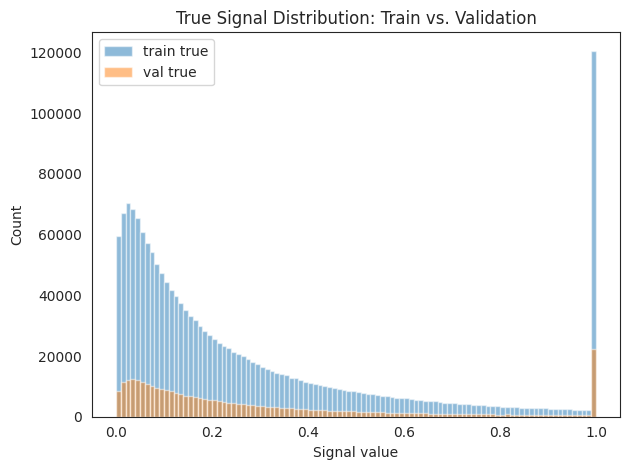

In [8]:
# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=100, alpha=0.5, label="train true")
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


Training sees 3840 unique trading days per epoch.

Using HyperParameters:
 "look_back": 60 {'SHORT_UNITS': 128, 'LONG_UNITS': 128, 'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.3, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.2, 'WEIGHT_DECAY': 0.003, 'CONV_K': 3, 'CONV_DILATION': 1, 'SMOOTH_K': 3, 'SMOOTH_DILATION': 1, 'TRAIN_BATCH': 64, 'VAL_BATCH': 1, 'NUM_WORKERS': 12, 'TRAIN_PREFETCH_FACTOR': 4, 'MAX_EPOCHS': 100, 'EARLY_STOP_PATIENCE': 7, 'LR_EPOCHS_WARMUP': 3, 'INITIAL_LR': 0.0002, 'CLIPNORM': 3, 'ETA_MIN': 1e-06, 'T_0': 100, 'T_MULT': 1, 'DIFF1_WEIGHT': 1.0, 'DIFF2_WEIGHT': 0.2, 'SMOOTH_ALPHA': 0.05, 'SMOOTH_BETA': 15.0, 'SMOOTH_DELTA': 0.005, 'HUBER_BETA': 0.1, 'CLS_LOSS_WEIGHT': 0.1, 'PLATEAU_FACTOR': 0.9, 'PLATEAU_PATIENCE': 0, 'MIN_LR': 1e-06, 'PLAT_EPOCHS_WARMUP': 999}


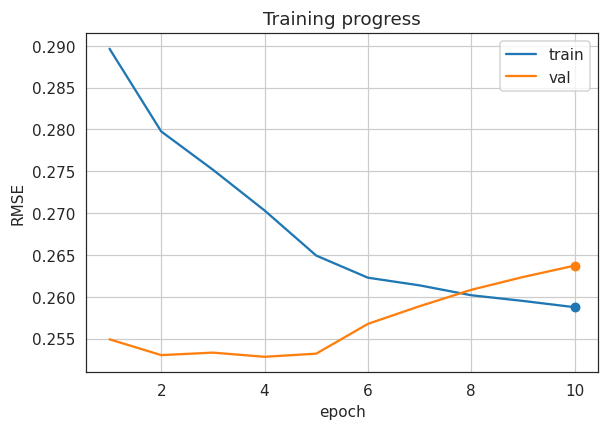

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.25491_chp.pth
Epoch 001
TRAIN→ RMSE=0.28964 MAE=0.23783 R2=0.00569 | Acc=0.69778 Prec=0.34237 Rec=0.10042 F1=0.15530 AUROC=0.58169 | T_ACC=0.34249 T_P=0.34181 T_R=0.34249 T_F1=0.33759 T_AUC=0.52013
VALID→ RMSE=0.25491 MAE=0.19464 R2=0.21120 | Acc=0.72974 Prec=0.78818 Rec=0.08110 F1=0.14707 AUROC=0.73019 | T_ACC=0.34524 T_P=0.33611 T_R=0.34524 T_F1=0.33418 T_AUC=0.59354


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.25302_chp.pth
Epoch 002
TRAIN→ RMSE=0.27976 MAE=0.23220 R2=0.07238 | Acc=0.73622 Prec=0.55003 Rec=0.25534 F1=0.34877 AUROC=0.68430 | T_ACC=0.34736 T_P=0.34679 T_R=0.34736 T_F1=0.34474 T_AUC=0.53205
VALID→ RMSE=0.25302 MAE=0.19765 R2=0.22283 | Acc=0.75224 Prec=0.70266 Rec=0.23860 F1=0.35624 AUROC=0.74619 | T_ACC=0.40040 T_P=0.33451 T_R=0.40040 T_F1=0.32602 T_AUC=0.67583


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.27519 MAE=0.22989 R2=0.10248 | Acc=0.74932 Prec=0.59105 Rec=0.30454 F1=0.40197 AUROC=0.71537 | T_ACC=0.35273 T_P=0.35184 T_R=0.35273 T_F1=0.35210 T_AUC=0.54528
VALID→ RMSE=0.25332 MAE=0.19910 R2=0.22100 | Acc=0.75493 Prec=0.68657 Rec=0.27047 F1=0.38807 AUROC=0.74978 | T_ACC=0.41877 T_P=0.33409 T_R=0.41877 T_F1=0.32500 T_AUC=0.70360


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.25282_chp.pth
Epoch 004
TRAIN→ RMSE=0.27032 MAE=0.22609 R2=0.13396 | Acc=0.75536 Prec=0.61014 Rec=0.32038 F1=0.42014 AUROC=0.73283 | T_ACC=0.35500 T_P=0.35469 T_R=0.35500 T_F1=0.35464 T_AUC=0.55174
VALID→ RMSE=0.25282 MAE=0.19923 R2=0.22407 | Acc=0.75644 Prec=0.67199 Rec=0.29741 F1=0.41233 AUROC=0.75096 | T_ACC=0.41653 T_P=0.33418 T_R=0.41653 T_F1=0.32442 T_AUC=0.70194


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.26492 MAE=0.22068 R2=0.16818 | Acc=0.75854 Prec=0.62380 Rec=0.32033 F1=0.42330 AUROC=0.74382 | T_ACC=0.35503 T_P=0.35545 T_R=0.35503 T_F1=0.35449 T_AUC=0.55353
VALID→ RMSE=0.25319 MAE=0.20282 R2=0.22177 | Acc=0.75503 Prec=0.63297 Rec=0.35063 F1=0.45128 AUROC=0.75008 | T_ACC=0.39676 T_P=0.33387 T_R=0.39676 T_F1=0.32286 T_AUC=0.69612


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.26228 MAE=0.21851 R2=0.18471 | Acc=0.75980 Prec=0.62646 Rec=0.32620 F1=0.42902 AUROC=0.74978 | T_ACC=0.35338 T_P=0.35355 T_R=0.35338 T_F1=0.35226 T_AUC=0.55031
VALID→ RMSE=0.25676 MAE=0.21073 R2=0.19973 | Acc=0.74989 Prec=0.59982 Rec=0.38895 F1=0.47190 AUROC=0.74732 | T_ACC=0.38526 T_P=0.33374 T_R=0.38526 T_F1=0.32170 T_AUC=0.68889


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.26136 MAE=0.21821 R2=0.19039 | Acc=0.76139 Prec=0.62705 Rec=0.33916 F1=0.44021 AUROC=0.75473 | T_ACC=0.35365 T_P=0.35351 T_R=0.35365 T_F1=0.35190 T_AUC=0.55326
VALID→ RMSE=0.25887 MAE=0.21318 R2=0.18652 | Acc=0.74782 Prec=0.59324 Rec=0.38892 F1=0.46983 AUROC=0.74520 | T_ACC=0.38674 T_P=0.33373 T_R=0.38674 T_F1=0.32249 T_AUC=0.69233


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.26018 MAE=0.21730 R2=0.19769 | Acc=0.76300 Prec=0.63050 Rec=0.34609 F1=0.44688 AUROC=0.75939 | T_ACC=0.35324 T_P=0.35326 T_R=0.35324 T_F1=0.35113 T_AUC=0.55226
VALID→ RMSE=0.26083 MAE=0.21466 R2=0.17415 | Acc=0.74531 Prec=0.58666 Rec=0.38420 F1=0.46432 AUROC=0.74136 | T_ACC=0.37866 T_P=0.33355 T_R=0.37866 T_F1=0.32263 T_AUC=0.69481


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.25950 MAE=0.21687 R2=0.20188 | Acc=0.76481 Prec=0.63281 Rec=0.35688 F1=0.45638 AUROC=0.76382 | T_ACC=0.35372 T_P=0.35287 T_R=0.35372 T_F1=0.35049 T_AUC=0.55202
VALID→ RMSE=0.26236 MAE=0.21564 R2=0.16444 | Acc=0.74168 Prec=0.57589 Rec=0.38269 F1=0.45982 AUROC=0.73761 | T_ACC=0.38797 T_P=0.33359 T_R=0.38797 T_F1=0.32286 T_AUC=0.69119


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.25875 MAE=0.21643 R2=0.20649 | Acc=0.76616 Prec=0.63314 Rec=0.36786 F1=0.46535 AUROC=0.76799 | T_ACC=0.35524 T_P=0.35363 T_R=0.35524 T_F1=0.35131 T_AUC=0.55260
VALID→ RMSE=0.26372 MAE=0.21689 R2=0.15574 | Acc=0.73581 Prec=0.55613 Rec=0.39850 F1=0.46430 AUROC=0.73451 | T_ACC=0.39681 T_P=0.33368 T_R=0.39681 T_F1=0.32337 T_AUC=0.67716


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Early stopping at epoch 11
✅ Final best model saved: AAPL_0.25282_fin.pth


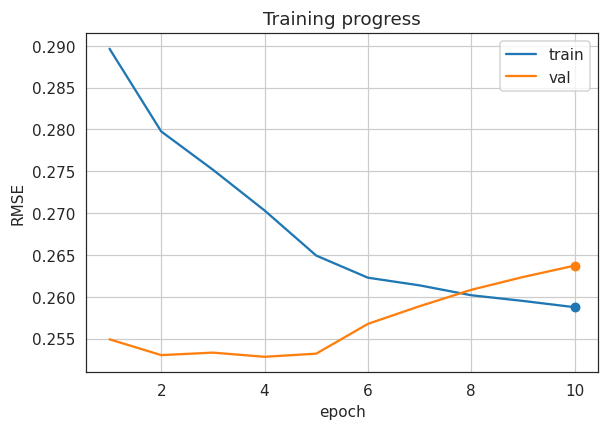

In [9]:
importlib.reload(params.model_selected) #############

# How many unique trading days does each epoch see?
n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

print('Using HyperParameters:\n "look_back":', params.look_back_tick, params.hparams)

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = params.model_selected.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    clipnorm            = clipnorm,
    device              = params.device,
    cls_loss_weight     = params.hparams['CLS_LOSS_WEIGHT'],
    smooth_alpha        = params.hparams['SMOOTH_ALPHA'],
    smooth_beta         = params.hparams['SMOOTH_BETA'],
    smooth_delta        = params.hparams['SMOOTH_DELTA'],
    diff1_weight        = params.hparams['DIFF1_WEIGHT'],
    diff2_weight        = params.hparams['DIFF2_WEIGHT'],
)


In [10]:
# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement_zero = 100.0 * (1.0 - best_val_rmse / rmse_zero_val)
print(f"Improvement over zero‐baseline = {improvement_zero:5.1f}%")

improvement_mean = 100.0 * (1.0 - best_val_rmse / rmse_mean_val)
print(f"Improvement over mean‐baseline = {improvement_mean:5.1f}%")



Champion validation RMSE = 0.252821
Improvement over zero‐baseline =  38.2%
Improvement over mean‐baseline =  11.9%
